## Geometric algorithms - convex hull

### Necessary imports

In [1]:
from random import uniform, seed
from math import sqrt, sin, cos, pi
from functools import cmp_to_key
from datetime import datetime
from datetime import timedelta
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

seed(1234)
np.random.seed(1234)

### Point class and needed methods

Point objects represent real coordinates on a plane. Implemented methods allow us to check alignment of 3 points and calculate distance.

In [2]:
class Point:

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def compare_angle(self, point2, point3):

        def determinant(point1, point2, point3):
            return point1.x * point2.y + point2.x * point3.y + point3.x * point1.y - point3.x * point2.y - \
                point2.x * point1.y - point1.x * point3.y

        epsilon = 10**(-12)
        det_value = determinant(self, point2, point3)

        if det_value < -epsilon:
            return 1
        elif det_value > epsilon:
            return -1
        else:
            return 0

    def distance(self, other):
        return sqrt((self.x-other.x)**2 + (self.y-other.y)**2)

    def __str__(self):
        return "({}, {})".format(self.x, self.y)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y


### Generators allowing us to get random points with given properties

<b>inside_rectangle</b> - generates points inside of a rectangle with given vertices<br>
<b>on_circle</b> - points lying on a circle with given center and radius<br>
<b>on_figure_edges</b> - points on the edges of a given figure (closed)<br>
<b>generate_dataset</b> - function allowing to aggregate points from all of the above sets with given counts<br>
<b>square_edges_and_diagonals</b> - points on square edges and diagonals

In [3]:
def inside_rectangle(params):
    while True:
        yield Point(uniform(params["min_value"], params["max_value"]),
                    uniform(params["min_value"], params["max_value"]))


def on_circle(params):
    while True:
        t = uniform(0, 2 * pi)
        yield Point(params["r"] * sin(t) + params["a"],
                    params["r"] * cos(t) + params["b"])


def on_figure_edges(params):
    points = params["points"]
    n = len(points)
    edges_lengths = [((points[i].x - points[(i + 1) % n].x) ** 2 +
                      (points[i].y - points[(i + 1) % n].y) ** 2) ** (1 / 2)
                     for i in range(n)]
    edges_length_sum = sum(edges_lengths)
    probabilities = [edges_lengths[i] / edges_length_sum for i in range(n)]
    a_params, b_params = [], []

    for i in range(n):
        if abs(points[i].x - points[(i + 1) % n].x) < 10 ** (-14):
            a_params.append(None)
            b_params.append(None)
        else:
            a_params.append(
                (points[i].y - points[(i + 1) % n].y) / (points[i].x - points[(i + 1) % n].x)
            )
            b_params.append(
                points[i].y - a_params[i] * points[i].x
            )

    while True:
        edge_number = np.random.choice([i for i in range(n)], p=probabilities)
        if a_params[edge_number] is None:
            x = points[edge_number].x
            y = uniform(
                min(points[edge_number].y, points[(edge_number + 1) % n].y),
                max(points[edge_number].y, points[(edge_number + 1) % n].y)
            )
        else:
            x = uniform(
                min(points[edge_number].x, points[(edge_number + 1) % n].x),
                max(points[edge_number].x, points[(edge_number + 1) % n].x)
            )
            y = a_params[edge_number] * x + b_params[edge_number]

        yield Point(x, y)


def generate_dataset(generators, params):
    dataset = []
    for i in range(len(params)):
        current_generator = generators[i](params[i])
        for _ in range(params[i]["counts"]):
            dataset.append(next(current_generator))

    return dataset


def square_edges_and_diagonals(params):
    diagonal1 = [params["points"][0], params["points"][2]]
    diagonal2 = [params["points"][1], params["points"][3]]
    edge1 = [params["points"][0], params["points"][1]]
    edge2 = [params["points"][0], params["points"][3]]

    return params["points"] + generate_dataset(
        [on_figure_edges, on_figure_edges, on_figure_edges, on_figure_edges],
        [{"points": diagonal1,
          "counts": params["on_diagonals_count"]},
         {"points": diagonal2,
          "counts": params["on_diagonals_count"]},
         {"points": edge1,
          "counts": params["on_edges_count"]},
         {"points": edge2,
          "counts": params["on_edges_count"]}]
    )

### Graham and Jarvis algorithms

Graham and Jarvis functions take <b>points</b> argument representing our dataset and other optional arguments, which include:<br>
<ul>
    <li><b>count_time</b> - defines whether it should calculate real time taken by the algorithm</li>
    <li><b>to_file</b> - string representing output file name (does not save if None)</li>
    <li><b>visualize</b> - defines whether to generate a gif showing how the algorithm works</li>
</ul>

In [4]:
def graham(points, count_time=False, to_file=None, visualize=False, save_to_file=False):
    
    def sort_points(points, base_point: Point):
        n = len(points)
        for i in range(n):
            if points[i][1] == base_point:
                del points[i]
                n -= 1
                break

        sorted_points = sorted(points, key=cmp_to_key(lambda x, y: (base_point.compare_angle(x[1], y[1]))))
        result = []

        i = 0
        while i < n:
            to_append_index, to_append_pt = sorted_points[i][0], sorted_points[i][1]
            while i < n-1 and base_point.compare_angle(sorted_points[i][1], sorted_points[i+1][1]) == 0:
                if base_point.distance(to_append_pt) < base_point.distance(sorted_points[i+1][1]):
                    to_append_index = sorted_points[i+1][0]
                    to_append_pt = sorted_points[i+1][1]
                i += 1
            result.append(to_append_index)
            i += 1

        return result

    if count_time:
        now = datetime.now()

    print("Calculating hull with Graham")
    n = len(points)
    epsilon = 10 ** (-12)
    initial_point = 0
    for i in range(1, n):
        if (abs(points[i].y - points[initial_point].y) < epsilon and points[i].x < points[initial_point].x) or \
                (points[i].y + epsilon < points[initial_point].y):
            initial_point = i

    sorted_points = sort_points(list(enumerate(points)), points[initial_point])

    hull = [initial_point, sorted_points[0], sorted_points[1]]
    i = 2
    m = len(sorted_points)

    if visualize:
        all_states = []
        hull_in_time = [hull[:]]
        states = ["green"] * n
        for p in hull:
            states[p] = "red"
        all_states.append(states[:])

    while i < m:
        if sorted_points[i] == initial_point:
            i += 1
            continue
        if points[hull[-2]].compare_angle(points[hull[-1]], points[sorted_points[i]]) == -1:
            hull.append(sorted_points[i])
            if visualize:
                states[sorted_points[i]] = "red"
                hull_in_time.append(hull[:])
            i += 1
        else:
            popped = hull.pop()
            if visualize:
                states[popped] = "blue"
                hull_in_time.append(hull[:])
        if visualize:
            all_states.append(states[:])
    print("Hull calculated")

    if count_time:
        working_time = datetime.now() - now
        print(working_time)

    if visualize:
        print("Preparing visualization...")
        graham_visualizer(points, all_states, hull_in_time, save_to_file)

    if to_file is not None:
        print("Saving results to file...")
        with open(to_file, "a+") as f:
            f.write(str(len(hull)) + '\n')
            for p in hull:
                f.write(str(points[p]) + "\n")
            f.write("\n")
    print("Done")

    if count_time:
        return hull, working_time
    
    return hull


def jarvis(points, visualize=False, count_time=False, to_file=None, save_to_file=False):
    
    def find_next(points, current, hull):
        n = len(points)
        for i in range(n):
            if points[hull[-2]].compare_angle(points[current], points[i]) < 1:
                min_point = i
                break

        for i in range(n):
            if i == current:
                continue
            if points[hull[-2]].compare_angle(points[current], points[i]) < 1:
                if points[current].compare_angle(points[min_point], points[i]) == 1:
                    min_point = i
                elif points[current].compare_angle(points[min_point], points[i]) == 0:
                    if points[current].distance(points[i]) > points[current].distance(points[min_point]):
                        min_point = i

        return min_point
    
    print("Calculating hull with Jarvis")
    if count_time:
        now = datetime.now()
    n = len(points)
    epsilon = 10**-12
    initial_point = 0
    for i in range(1, n):
        if (abs(points[i].y - points[initial_point].y) < epsilon and points[i].x < points[initial_point].x) or \
                (points[i].y + epsilon < points[initial_point].y):
            initial_point = i

    hull = [initial_point]
    if initial_point != 0:
            min_point = 0
    else:
        min_point = 1
    for i in range(n):
        if i == initial_point:
            continue

        if points[initial_point].compare_angle(points[min_point], points[i]) == 1:
            min_point = i
        elif points[initial_point].compare_angle(points[min_point], points[i]) == 0:
            if points[initial_point].distance(points[i]) > points[initial_point].distance(points[min_point]):
                min_point = i
    hull.append(min_point)
    
    while hull[-1] != hull[0]:
        hull.append(find_next(points, hull[-1], hull))

    result = [points[h] for h in hull]
    print("Hull calculated")

    if count_time:
        working_time = datetime.now() - now
        print(working_time)

    if visualize:
        print("Preparing visualization...")
        jarvis_visualizer(points, hull, save_to_file)

    if to_file is not None:
        print("Saving results to file...")
        with open(to_file, "w+") as f:
            for p in result:
                f.write(str(p) + '\n')
            f.write('\n')

    if count_time:
        return result, working_time
    print("Done")
    return result

### Visualizers for both of the functions

In [5]:
def graham_visualizer(points, states_in_time, hull_in_time, save_to_file):

    def next_anim(k):
        print("\r", end='')
        print(f"Frames left: {max(len(states_in_time)-k-1, 0)}", end='')
        print("                                    ", end='')
        scat.set_color(states_in_time[k])
        lines.set_xdata([points[hull_in_time[k][i]].x for i in range(len(hull_in_time[k]))])
        lines.set_ydata([points[hull_in_time[k][i]].y for i in range(len(hull_in_time[k]))])
        return scat, lines,

    states_in_time += [states_in_time[-1]] * (max(len(states_in_time)//30, 3) * 5)
    hull_in_time += [hull_in_time[-1] + [hull_in_time[-1][0]]] * (max(len(states_in_time)//30, 3) * 5)

    fig, ax = plt.subplots()
    

    if save_to_file:
        scat = ax.scatter([p.x for p in points], [p.y for p in points],
                      c=states_in_time[0])
        lines = ax.plot([points[hull_in_time[0][i]].x for i in range(len(hull_in_time[0]))],
                        [points[hull_in_time[0][i]].y for i in range(len(hull_in_time[0]))],
                        color="red")[0]
        anim = FuncAnimation(fig, next_anim, frames=len(states_in_time), blit=True)
        writergif = PillowWriter(fps=max(len(states_in_time)//30, 3))
        gif_out_name = "graham0.gif"
        f_name_count = 0
        while os.path.isfile(gif_out_name):
            f_name_count += 1
            gif_out_name = f"graham{f_name_count}.gif"
        anim.save(gif_out_name, writer=writergif)
        print(f"\nGif ready under {gif_out_name}")
    
    scat = ax.scatter([p.x for p in points], [p.y for p in points], c=states_in_time[-1])
    lines = ax.plot([points[hull_in_time[-1][i]].x for i in range(len(hull_in_time[-1]))],
                    [points[hull_in_time[-1][i]].y for i in range(len(hull_in_time[-1]))],
                    color="red")[0]
    plt.show()
    


def jarvis_visualizer(points, hull, save_to_file):

    def next_anim(k):
        print("\r", end='')
        print(f"Frames left: {max(len(hull)-k-1, 0)}", end='')
        print("                                    ", end='')
        lines.set_xdata(xs[:k])
        lines.set_ydata(ys[:k])
        if k < len(hull):
            colors[hull[k]] = "red"
            scat.set_color(colors)
        return scat, lines,

    xs, ys = [points[h].x for h in hull], [points[h].y for h in hull]
    xs += [xs[0]] * 10
    ys += [ys[0]] * 10
    colors = ["green"] * len(points)
    fig, ax = plt.subplots()
    scat = ax.scatter([p.x for p in points], [p.y for p in points], c='green')
    lines = ax.plot([], [], color='red')[0]
    
    if save_to_file:
        anim = FuncAnimation(fig, next_anim, frames=len(xs), blit=True)
        writergif = PillowWriter(fps=max(len(xs)//30, 3))
        gif_out_name = "jarvis0.gif"
        f_name_count = 0
        while os.path.isfile(gif_out_name):
            f_name_count += 1
            gif_out_name = f"jarvis{f_name_count}.gif"
        anim.save(gif_out_name, writer=writergif)
        print(f"\nGif ready under {gif_out_name}")
    
    for i in range(len(hull)):
        colors[hull[i]] = "red"
    scat = ax.scatter([p.x for p in points], [p.y for p in points], c=colors)
    lines = ax.plot(xs, ys, color="red")[0]
    plt.show()
    


### Example datasets and their plots

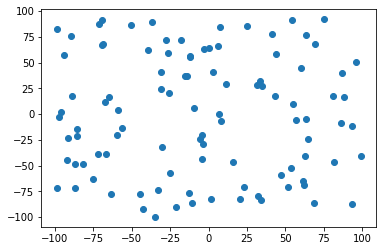

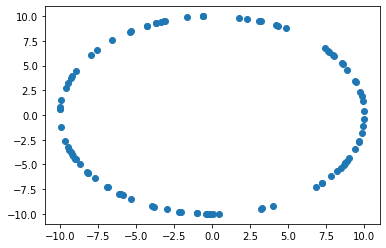

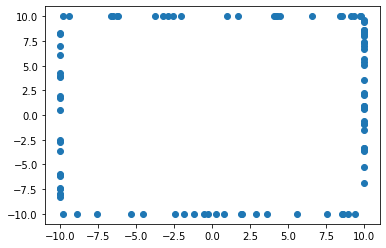

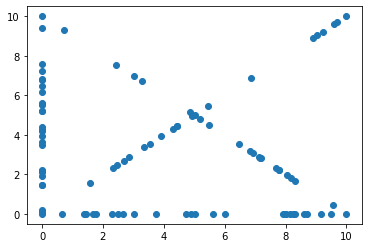

In [6]:
%matplotlib inline

def show_dataset(points):
    plt.scatter([p.x for p in points], [p.y for p in points])
    plt.show()
    
datasets = []

datasets.append(generate_dataset([inside_rectangle], [{"min_value": -100, "max_value": 100, "counts": 100}]))

datasets.append(generate_dataset([on_circle], [{"a": 0, "b": 0, "r": 10, "counts": 100}]))

datasets.append(generate_dataset([on_figure_edges], [{"points": [Point(-10, 10), Point(-10, -10), 
                                                                 Point(10, -10), Point(10, 10)], "counts": 100}]))

datasets.append(square_edges_and_diagonals({"points": [Point(0, 0), Point(10, 0),
                                                                            Point(10, 10), Point(0, 10)],
                                                                "on_diagonals_count": 20, "on_edges_count": 25}))


for dataset in datasets:
    show_dataset(dataset)

### Calculating convex hull for some datasets

Calculating hull with Graham
Hull calculated
Preparing visualization...


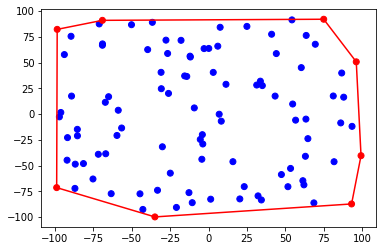

Done
Calculating hull with Jarvis
Hull calculated
Preparing visualization...


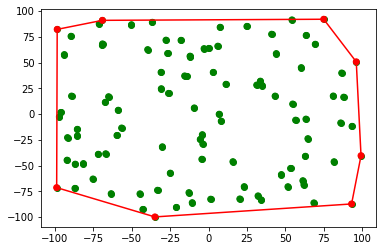

Done


In [7]:
_ = graham(datasets[0], visualize=True)
_ = jarvis(datasets[0], visualize=True)

Calculating hull with Graham
Hull calculated
Preparing visualization...


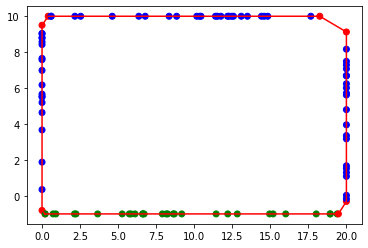

Done
Calculating hull with Jarvis
Hull calculated
Preparing visualization...


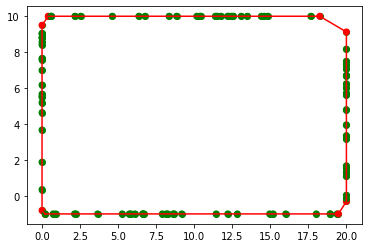

Done


In [8]:
test_dataset3 = generate_dataset([on_figure_edges], [{"points": [Point(0, -1), Point(0, 10), Point(20, 10), Point(20, -1)],
                                                      "counts": 100}])
_ = graham(test_dataset3, visualize=True)
_ = jarvis(test_dataset3, visualize=True)

Calculating hull with Graham
Hull calculated
Preparing visualization...


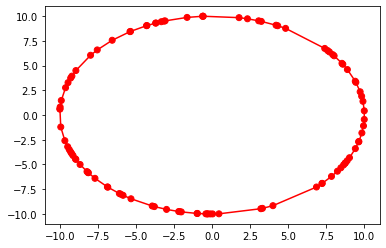

Done
Calculating hull with Jarvis
Hull calculated
Preparing visualization...


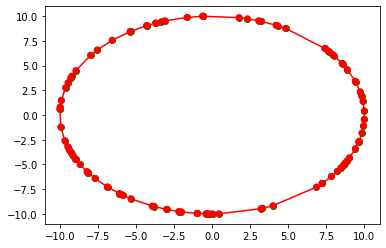

Done
Calculating hull with Graham
Hull calculated
Preparing visualization...


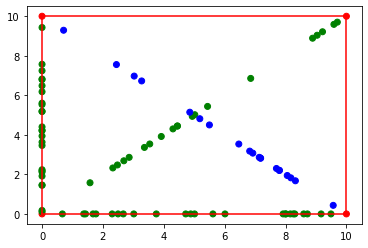

Done
Calculating hull with Jarvis
Hull calculated
Preparing visualization...


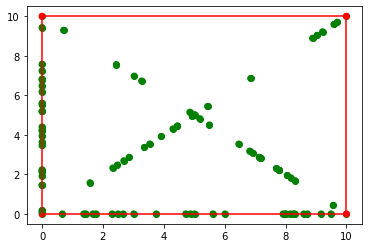

Done


In [9]:
for i in [1, 3]:
    graham(datasets[i], visualize=True)
    jarvis(datasets[i], visualize=True)

### Testing time taken by each of the algorithms

In [12]:
time_datasets_type = []

max_elements = [1000, 1000, 1000, 1000]
step = [100, 100, 100, 100]
min_elements = step[:]

time_datasets_type.append(generate_dataset([inside_rectangle], [{"min_value": -100, "max_value": 100, 
                                                                 "counts": max_elements[0]}]))
time_datasets_type.append(generate_dataset([on_circle], [{"a": 0, "b": 0, "r": 10, "counts": max_elements[1]}]))
time_datasets_type.append(generate_dataset([on_figure_edges], [{"points": [Point(-10, 10), Point(-10, -10), 
                                                                           Point(10, -10), Point(10, 10)],
                                                                "counts": max_elements[2]}]))
time_datasets_type.append(square_edges_and_diagonals({"points": [Point(0, 0), Point(10, 0),
                                                                 Point(10, 10), Point(0, 10)],
                                                      "on_diagonals_count": max_elements[3]//4,
                                                      "on_edges_count": max_elements[3]//4}))

time_taken_graham = [[] for i in range(4)]
time_taken_jarvis = [[] for i in range(4)]
elements_count = [[] for i in range(4)]

old_stdout = sys.stdout
f = open(os.devnull, 'w')
sys.stdout = f

for i in range(4): 
    for j in range(min_elements[i], max_elements[i]+1, step[i]):
        elements_count[i].append(j)
        print(j)
        print(len(time_datasets_type[i]))
        _, new_time_graham = graham(time_datasets_type[i][:j], count_time=True)
        time_taken_graham[i].append(new_time_graham / timedelta(seconds=1))

        _, new_time_jarvis = jarvis(time_datasets_type[i][:j], count_time=True)
        time_taken_jarvis[i].append(new_time_jarvis / timedelta(seconds=1))

f.close()
sys.stdout = old_stdout


In [13]:
with open("times.txt", "w+") as f:
    for i in range(4):
        for c in elements_count[i]:
            f.write(str(c) + " ")
        f.write("\n")
        for t in time_taken_graham[i]:
            f.write(str(t) + " ")
        f.write("\n")
        for t in time_taken_jarvis[i]:
            f.write(str(t) + " ")
        f.write("\n")

In [14]:
time_taken_graham = [[] for _ in range(4)]
time_taken_jarvis = [[] for _ in range(4)]
elements_count = []

with open("times.txt", "r") as f:
    for i in range(4):
        elements_count.append(list(map(int, f.readline().split())))
        time_taken_graham[i].append(list(map(float, f.readline().split())))
        time_taken_jarvis[i].append(list(map(float, f.readline().split())))

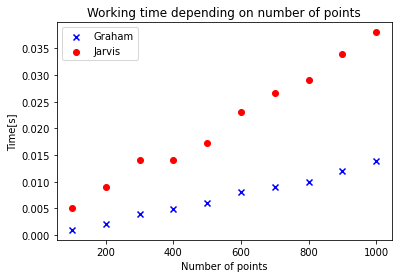

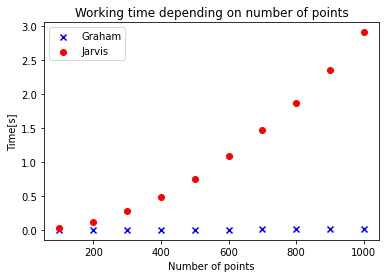

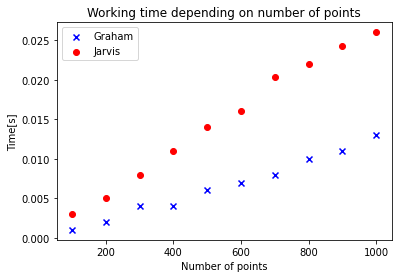

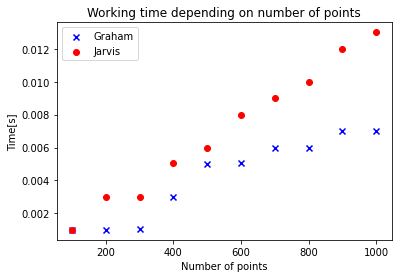

In [15]:
for i in range(4):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(elements_count[i], time_taken_graham[i], color="blue", marker='x', label="Graham")
    ax.scatter(elements_count[i], time_taken_jarvis[i], color="red", marker='o', label="Jarvis")
    plt.legend(loc="upper left")
    plt.title("Working time depending on number of points")
    plt.xlabel("Number of points")
    plt.ylabel("Time[s]")
    plt.show()

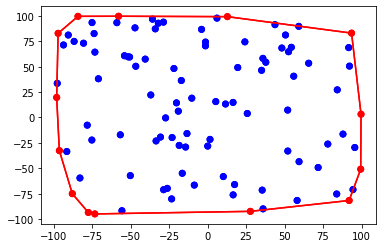

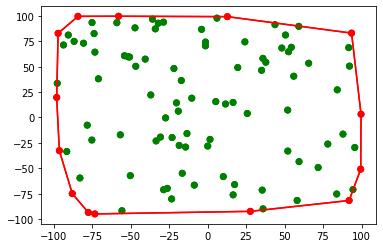

In [16]:
count = 100
gif_dataset = generate_dataset([inside_rectangle], [{"counts": count, "min_value": -100, "max_value": 100}])
_ = graham(gif_dataset, visualize=True, save_to_file=True)
_ = jarvis(gif_dataset, visualize=True, save_to_file=True)